In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

from Quantum_Kernel import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
sto_index_sets = []
sto_index_test_sets =[]
datasets_X_S =[]
datasets_y =[]
gram_gaussian_set =[]
gram_gaussian_test_set = []
gram_zz_kernel_set = []
gram_zz_kernel_test_set = [] 
gram_kernel_set = []
gram_kernel_test_set = []
folder = "svm_data4"

for i in range(5):
    sto_index_sets += [pd.read_csv(folder + "/sto_index_sets"+str(i)+".csv").iloc[:,1].tolist()]
    sto_index_test_sets += [pd.read_csv(folder + "/sto_index_test_sets"+str(i)+".csv").iloc[:,1].tolist()]
    datasets_X_S += [pd.read_csv(folder + "/datasets_X_S"+str(i)+".csv").iloc[:,1:].values.tolist()]
    datasets_y += [pd.read_csv(folder + "/datasets_y"+str(i)+".csv").iloc[:,1].values.tolist()]
    
    gram_gaussian_set += [pd.read_csv(folder + "/gram_gaussian_"+str(i)+".csv").iloc[:,1:].values.tolist()]
    gram_gaussian_test_set += [pd.read_csv(folder + "/gram_gaussian_test"+str(i)+".csv").iloc[:,1:].values.tolist()]
    gram_zz_kernel_set += [pd.read_csv(folder + "/gram_zz_kernel"+str(i)+".csv").iloc[:,1:].values.tolist()]
    gram_zz_kernel_test_set += [pd.read_csv(folder + "/gram_zz_kernel_test"+str(i)+".csv").iloc[:,1:].values.tolist()]
    gram_kernel_set += [pd.read_csv(folder + "/gram_kernel"+str(i)+".csv").iloc[:,1:].values.tolist()]
    gram_kernel_test_set += [pd.read_csv(folder + "/gram_kernel_test"+str(i)+".csv").iloc[:,1:].values.tolist()]

In [3]:
i=0
comp=3
gram_gaussian_set = []
gram_gaussian_test_set = []

for i in range(5):

    sto_ind = sto_index_sets[i]
    data_sto_y =pd.DataFrame(datasets_y[i]).iloc[sto_ind,:].values.reshape(-1)
    data_sto = np.array(datasets_X_S[i])[sto_ind,:]

    sto_ind = sto_index_test_sets[i]
    data_sto_test_y =pd.DataFrame(datasets_y[i]).iloc[sto_ind,:].values.reshape(-1)
    data_sto_test = np.array(datasets_X_S[i])[sto_ind,:]

    gram_gaussian_set += [Gram_gaussian(data=data_sto,comp=comp)]
    gram_gaussian_test_set += [Gram_gaussian_test(data_sto,data_sto_test,comp=comp)]

In [4]:
kernel_list = [gram_gaussian_set,gram_zz_kernel_set,gram_kernel_set]
kernel_test_list = [gram_gaussian_test_set,gram_zz_kernel_test_set,gram_gaussian_test_set]
total_result = []
for j in range(3):
    kernel_set = kernel_list[j]
    kernel_test_set = kernel_test_list[j] 

    train_score = []
    test_score = []
    svm = SVM(1)

    for i in range(5):
        sto_ind = sto_index_sets[i]
        data_sto_y =pd.DataFrame(datasets_y[i]).iloc[sto_ind,:]
    
        sto_ind = sto_index_test_sets[i]
        data_sto_test_y =pd.DataFrame(datasets_y[i]).iloc[sto_ind,:]
    
        kernel_matrix = kernel_set[i]
        kernel_test_matrix = kernel_test_set[i]

        svm.fit(kernel_matrix,data_sto_y)
        train_score += [svm.score(kernel_matrix,data_sto_y)]
        test_score += [svm.score(kernel_test_matrix,data_sto_test_y)]


    result = pd.DataFrame([train_score,test_score])
    result.index = ["Train Score","Test Score"]
    result.columns = ["Data Set 1","Data Set 2","Data Set 3","Data Set 4","Data Set 5"]
    total_result += result.values.tolist()
total_result = pd.DataFrame(total_result)
total_result.index = ["Gaussian_Train","Gaussian_Test","zz_kernel_Train","zz_kerenl_Test","custom_kernel_Train","custom_kerenl_Test"]
total_result.columns = ["Data Set 1","Data Set 2","Data Set 3","Data Set 4","Data Set 5"]
total_result.to_csv(folder + "/SVM_Result.csv")

In [5]:
total_result

,Data Set 1,Data Set 2,Data Set 3,Data Set 4,Data Set 5
Gaussian_Train,0.97,0.90,1.00,0.95,0.86
Gaussian_Test,0.97,0.94,1.00,0.93,0.81
zz_kernel_Train,0.75,0.88,0.76,0.78,0.64
zz_kerenl_Test,0.70,0.88,0.69,0.71,0.53
custom_kernel_Train,0.84,0.90,0.81,0.79,0.86
custom_kerenl_Test,0.94,0.95,1.00,0.91,0.84


In [6]:
class SVM():
    def __init__(self,lamda=1):
        self.lamda = lamda
    
    def fit(self,kernel_matrix,y_train_ori):

        y_train = np.asarray(2.0*(y_train_ori==list(set(y_train_ori))[0])-1).reshape(-1)
        k=1000

        n = len(kernel_matrix[0])
        upbound = 2*n*self.lamda
        Q_mat = np.matmul(np.matmul(np.diag(y_train),kernel_matrix),np.diag(y_train))
        Q = matrix(Q_mat)
        r = matrix(k*np.array([1.0 for i in range(n)]))

        G = matrix(np.concatenate([-np.eye(n),np.eye(n)]))
        h = matrix([0.0 for i in range(n)] + [upbound**(-1) for i in range(n)])
        A = matrix(y_train).T
        b = matrix(0.0)

        sol = qp(Q,r,A,b,G,h, kktsolver='ldl', options={'kktreg':1e-9,'show_progress': False})

        c_sol = [sol["x"]]
        self.coef = [i for i in c_sol[0]]
        self.train_gram = kernel_matrix
        self.y_train = y_train
        self.y_train_ori = y_train_ori
    
    def predict(self,kernel_matrix_pred):
        y_pred = np.sign(np.matmul((self.coef * self.y_train),kernel_matrix_pred))
        return(y_pred)
    
    def score(self,kernel_matrix_pred,y_true):
        n = len(y_true)
        y_true = np.asarray(2.0*(y_true==list(set(self.y_train_ori))[0])-1).reshape(-1)
        y_pred = self.predict(kernel_matrix_pred)
        return(sum(y_pred==y_true)/n)

In [7]:
y_train = data_sto_y
kernel_matrix = kernel_set[0]
kernel_matrix_pred = kernel_test_set[0]
y_train_ori = data_sto_y
lamda = 1

In [8]:

y_train = np.asarray(2.0*(y_train_ori==list(set(y_train_ori))[0])-1).reshape(-1)
k=10

n = len(kernel_matrix[0])
upbound = 2*n*lamda
Q_mat = np.matmul(np.matmul(np.diag(y_train),kernel_matrix),np.diag(y_train))
Q = matrix(Q_mat)
r = matrix(k*np.array([1.0 for i in range(n)]))

G = matrix(np.concatenate([-np.eye(n),np.eye(n)]))
h = matrix([0.0 for i in range(n)] + [upbound**(-1) for i in range(n)])
A = matrix(y_train).T
b = matrix(0.0)

sol = qp(Q,r,A,b,G,h, kktsolver='ldl', options={'kktreg':1e-9,'show_progress': False})

c_sol = [i for i in sol["x"]]


In [9]:
kernel_list = [gram_gaussian_set,gram_zz_kernel_set,gram_kernel_set]
kernel_test_list = [gram_gaussian_test_set,gram_zz_kernel_test_set,gram_gaussian_test_set]
total_result = []
for j in range(3):
    kernel_set = kernel_list[j]
    kernel_test_set = kernel_test_list[j] 

    train_score = []
    test_score = []
    svm = SVM(1)

    for i in range(5):
        sto_ind = sto_index_sets[i]
        data_sto_y =pd.DataFrame(datasets_y[i]).iloc[sto_ind,:]
    
        sto_ind = sto_index_test_sets[i]
        data_sto_test_y =pd.DataFrame(datasets_y[i]).iloc[sto_ind,:]
    
        kernel_matrix = kernel_set[i]
        kernel_test_matrix = kernel_test_set[i]

        svm.fit(kernel_matrix,data_sto_y)
        train_score += [svm.score(kernel_matrix,data_sto_y)]
        test_score += [svm.score(kernel_test_matrix,data_sto_test_y)]


    result = pd.DataFrame([train_score,test_score])
    result.index = ["Train Score","Test Score"]
    result.columns = ["Data Set 1","Data Set 2","Data Set 3","Data Set 4","Data Set 5"]
    total_result += result.values.tolist()
total_result = pd.DataFrame(total_result)
total_result.index = ["Gaussian_Train","Gaussian_Test","zz_kernel_Train","zz_kerenl_Test","custom_kernel_Train","custom_kerenl_Test"]
total_result.columns = ["Data Set 1","Data Set 2","Data Set 3","Data Set 4","Data Set 5"]
total_result.to_csv(folder + "/SVM_Result.csv")
total_result

,Data Set 1,Data Set 2,Data Set 3,Data Set 4,Data Set 5
Gaussian_Train,0.96,0.90,1.00,0.95,0.89
Gaussian_Test,0.90,0.96,1.00,0.93,0.84
zz_kernel_Train,0.75,0.86,0.79,0.88,0.64
zz_kerenl_Test,0.69,0.82,0.79,0.76,0.53
custom_kernel_Train,0.86,0.89,0.77,0.76,0.87
custom_kerenl_Test,0.90,0.96,1.00,0.93,0.84


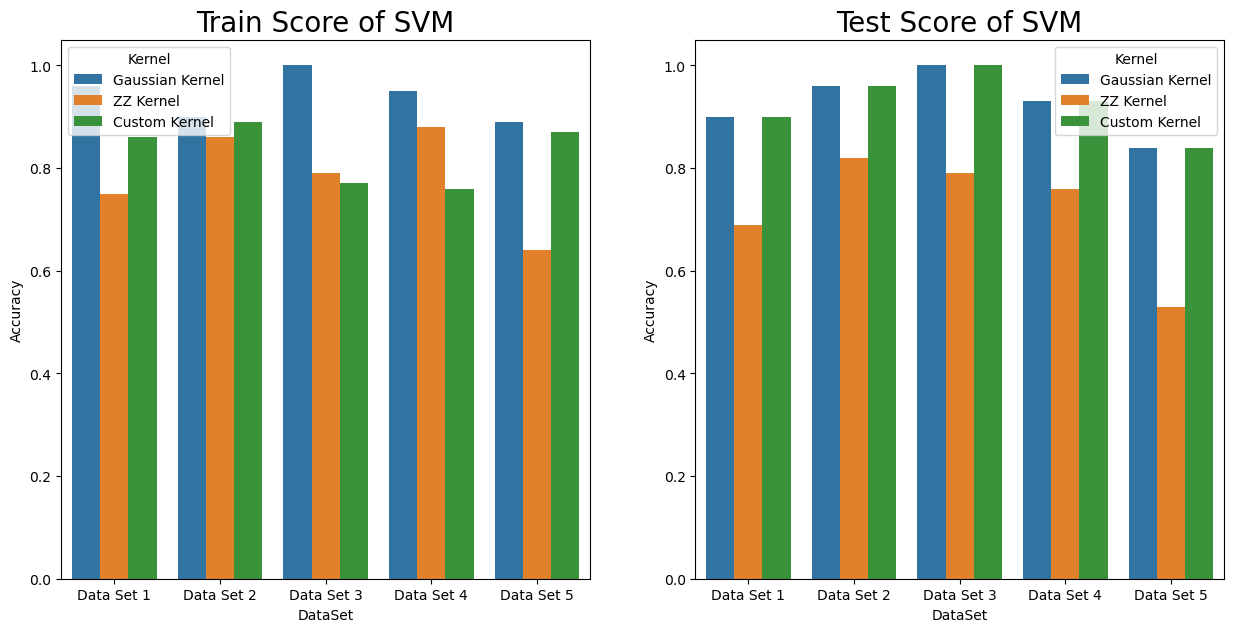

In [10]:
plot_train = pd.DataFrame(pd.concat([total_result.iloc[0,:],total_result.iloc[2,:],total_result.iloc[4,:]]))
plot_train.columns = ["Accuracy"]
plot_train["DataSet"] = plot_train.index
plot_train["Kernel"] = ["Gaussian Kernel" for i in range(5)]+["ZZ Kernel" for i in range(5)]+["Custom Kernel" for i in range(5)]

plot_test = pd.DataFrame(pd.concat([total_result.iloc[1,:],total_result.iloc[3,:],total_result.iloc[5,:]]))
plot_test.columns = ["Accuracy"]
plot_test["DataSet"] = plot_test.index
plot_test["Kernel"] = ["Gaussian Kernel" for i in range(5)]+["ZZ Kernel" for i in range(5)]+["Custom Kernel" for i in range(5)]

plt.figure(figsize = (15,7))
plt.subplot(121)
sns.barplot(data=plot_train, x="DataSet", y="Accuracy", hue="Kernel").axes.set_title(label="Train Score of SVM",fontsize=20)
plt.subplot(122)
sns.barplot(data=plot_test, x="DataSet", y="Accuracy", hue="Kernel").axes.set_title(label="Test Score of SVM",fontsize=20)

plt.savefig(folder + "/SVM_result.jpg")
plt.show()

In [11]:
total_result

,Data Set 1,Data Set 2,Data Set 3,Data Set 4,Data Set 5
Gaussian_Train,0.96,0.90,1.00,0.95,0.89
Gaussian_Test,0.90,0.96,1.00,0.93,0.84
zz_kernel_Train,0.75,0.86,0.79,0.88,0.64
zz_kerenl_Test,0.69,0.82,0.79,0.76,0.53
custom_kernel_Train,0.86,0.89,0.77,0.76,0.87
custom_kerenl_Test,0.90,0.96,1.00,0.93,0.84


In [12]:
gram_kernel_set = []
gram_kernel_test_set = []
folder = "pendigit4"
sto_index = pd.read_csv(folder + "/sto_index.csv").iloc[:,1].tolist()
sto_index_test = pd.read_csv(folder + "/sto_test_index.csv").iloc[:,1].tolist()
datasets_X_S = pd.read_csv(folder + "/datasets_X_S.csv").iloc[:,1:]
datasets_y = pd.read_csv(folder + "/datasets_y.csv").iloc[:,1:]
    
for i in range(7):
    gram_kernel_set += [pd.read_csv(folder + "/gram_kernel"+str(i)+".csv").iloc[:,1:].values.tolist()]
    gram_kernel_test_set += [pd.read_csv(folder + "/gram_kernel_test"+str(i)+".csv").iloc[:,1:].values.tolist()]
data_sto = np.array(datasets_X_S)[sto_index,:]
data_sto_test = np.array(datasets_X_S)[sto_index_test,:]
comp=1

gram_kernel_set[0] = Gram_gaussian(data=data_sto,comp=comp)
gram_kernel_test_set[0] = Gram_gaussian_test(data_sto,data_sto_test,comp=comp)

In [13]:
data_sto = np.array(datasets_X_S)[sto_index,:]
data_sto_test = np.array(datasets_X_S)[sto_index_test,:]
comp=1

gram_kernel_set[0] = Gram_gaussian(data=data_sto,comp=comp)
gram_kernel_test_set[0] = Gram_gaussian_test(data_sto,data_sto_test,comp=comp)

In [38]:
gram_kernel_set = []
gram_kernel_test_set = []
folder = "pendigit_layer2"
sto_index = pd.read_csv(folder + "/sto_index.csv").iloc[:,1].tolist()
sto_index_test = pd.read_csv(folder + "/sto_test_index.csv").iloc[:,1].tolist()
datasets_X_S = pd.read_csv(folder + "/datasets_X_S.csv").iloc[:,1:]
datasets_y = pd.read_csv(folder + "/datasets_y.csv").iloc[:,1:]
n_kernel = 4
for i in range(n_kernel):
    gram_kernel_set += [pd.read_csv(folder + "/gram_kernel"+str(i)+".csv").iloc[:,1:].values.tolist()]
    gram_kernel_test_set += [pd.read_csv(folder + "/gram_kernel_test"+str(i)+".csv").iloc[:,1:].values.tolist()]
data_sto = np.array(datasets_X_S)[sto_index,:]
data_sto_test = np.array(datasets_X_S)[sto_index_test,:]
data_sto_y = np.array(datasets_y)[sto_index,0]
data_sto_test_y = np.array(datasets_y)[sto_index_test,0]

comp=3
gram_kernel_set[0] = Gram_gaussian(data=data_sto,comp=comp)
gram_kernel_test_set[0] = Gram_gaussian_test(data_sto,data_sto_test,comp=comp)

In [54]:
y_train = data_sto_y
kernel_set = gram_kernel_set
kernel_test_set = gram_kernel_test_set

kernel_matrix = kernel_set[0]
kernel_matrix_pred = kernel_test_set[0]
y_train_ori = data_sto_y
lamda = 1

In [55]:
set_y = list(set(y_train))
n_y = len(set_y)
svm = SVM(10)
coef_list = []
for k in range(n_y):
    y_temp = y_train == set_y[k]
    svm.fit(kernel_matrix,y_temp)
    coef_list += [svm.coef]
coef = coef_list
y_pred = []
set_y = list(set(y_train))
n_y = len(set_y)
for j in range(n_y) :
    y_temp = np.asarray(2.0*(y_train == set_y[k])-1).reshape(-1)
    y_pred += [np.sign(np.matmul((coef[j] * y_temp),kernel_matrix_pred))]

In [57]:
pd.DataFrame(y_pred)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,...,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0
1,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,...,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0
2,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,...,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0


In [ ]:
class SVM():
    def __init__(self,lamda=1):
        self.lamda = lamda
    
    def fit(self,kernel_matrix,y_train_ori):

        y_train = np.asarray(2.0*(y_train_ori==list(set(y_train_ori))[0])-1).reshape(-1)
        k=1000

        n = len(kernel_matrix[0])
        upbound = 2*n*self.lamda
        Q_mat = np.matmul(np.matmul(np.diag(y_train),kernel_matrix),np.diag(y_train))
        Q = matrix(Q_mat)
        r = matrix(k*np.array([1.0 for i in range(n)]))

        G = matrix(np.concatenate([-np.eye(n),np.eye(n)]))
        h = matrix([0.0 for i in range(n)] + [upbound**(-1) for i in range(n)])
        A = matrix(y_train).T
        b = matrix(0.0)

        sol = qp(Q,r,A,b,G,h, kktsolver='ldl', options={'kktreg':1e-9,'show_progress': False})

        c_sol = [sol["x"]]
        self.coef = [i for i in c_sol[0]]
        self.train_gram = kernel_matrix
        self.y_train = y_train
        self.y_train_ori = y_train_ori
    
    def predict(self,kernel_matrix_pred):
        y_pred = np.sign(np.matmul((self.coef * self.y_train),kernel_matrix_pred))
        return(y_pred)
    
    def score(self,kernel_matrix_pred,y_true):
        n = len(y_true)
        y_true = np.asarray(2.0*(y_true==list(set(self.y_train_ori))[0])-1).reshape(-1)
        y_pred = self.predict(kernel_matrix_pred)
        return(sum(y_pred==y_true)/n)

In [ ]:
class multiclass_SVM():
    def __init__(self,lamda=1):
        self.lamda = lamda
        self.svm = SVM()

    def fit(self,kernel_matrix,y_train):
        set_y = list(set(y_train))
        n_y = len(set_y)
        for k in range(n_y):
            y_temp = y_train == set_y[k]
            svm.fit(kernel_matrix,y_temp)
            coef_list += [svm.coef]
        self.coef = coef_list
        self.y_train = y_train

    def predict(self,kernel_matrix_pred):
        y_pred = []
        set_y = list(set(y_train))
        n_y = len(set_y)
        for j in range(n_y) :
            y_temp = y_train == set_y[k]
            y_pred += [np.sign(np.matmul((self.coef[j] * self.y_train),kernel_matrix_pred))]
        return(y_pred)